In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

This notebook was written to demonstrate the Backward Kolmogorov equation, in relation to this post:

https://math.stackexchange.com/questions/4982195/intuitive-explanation-of-the-backward-kolmogorov-equation

# Background and theory

For an SDE

$$ dX = a(X, t) dt + b(X, t) dW_t, $$

there is a transition density, $p(y, s; x, t)$, describing the probability density for a solution that has value $y$ at time $s$ to have value $x$ at time $t$, with $s \leq t$. This transition density, which we will call $p$ for short, obeys the forward and backward Kolmogorov equations, provided that $a$ and $b$ are "moderately smooth functions" ([Kloeden & Platen][2], p. 37 ).

Just for completeness, the forward equation is

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \big( a(x, t) \, p \big) + \frac{1}{2} \frac{\partial^2}{\partial x^2} \big( b^2(x, t) \, p \big), \;\;\;\textrm{keeping $y,s$ fixed},$$
and the backward equation is
$$ \frac{\partial p}{\partial s} = - a(y, s) \frac{\partial p}{\partial y} - \frac{1}{2} b(y, s)^2 \frac{\partial^2 p}{\partial y^2}, \;\;\;\textrm{keeping $x, t$ fixed}. $$

The point of the backward equation is that if we observe that a solution has value $x$, at time $t$, it can tell us the distribution of most likely values $y$, at an earlier time $t$. Or to put it in practical terms, if we observe an oil spill or a life raft or whatever, we can find the most likely locations it came from, at some earlier time, given the observation and the advection and diffusion describing the problem.

To illustrate the backward equation, I will use an SDE that I will call the forward SDE,

$$ dX = \big(v + K'(X, t) \big)\, dt + \sqrt{2K(X, t)}\, dW_t, $$

where $K(x, t)$ is the diffusivity, $K' = \partial K / \partial x$, and $v$ is a constant advection velocity. It is left as an exercise to the reader to verify that the forward Kolmogorov equation in this case becomes the advection-diffusion equation.

Additionally, I will use an SDE which I will call the backward SDE (see Eq. (20) in [Shah et al, 2007][3]),
$$ dX = \big(-v + K'(X, t) \big)\, dt + \sqrt{2K(X, t)}\, dW_t. $$
Basically this equation has the backward Kolmogorov equation for the forward SDE as it's forward Kolmogorov equation, so that modelling the backward SDE forwards in time is equivalent to modelling the forwards SDE backwards in time. If that makes sense.

To try to make this a bit more concrete, I will do three different numerical demos. For all three, I will assume that we have made an observation of a distribution of solutions, uniformly distributed on the interval $[x_0 - \Delta x, x_0 + \Delta x]$, and I will be asking where these particles most likely came from, given that their motion (forwards in time) is controlled by the forward SDE. I will do the following:
 * Starting out with a uniform distribution $[x_0 - \Delta x, x_0 + \Delta x]$, at time $t$, I will use the backward SDE to find the distribution at the earlier time $s$.
 * Starting out with a very wide, uniform distribution at time $s$, I will use the forward SDE to model the transport until the later time $t$, and then keep only those solutions that ended up inside the interval $[x_0 - \Delta x, x_0 + \Delta x]$ at time $t$, and look at their
initial distribution at time $s$.
 * Starting with $$p(y,s; x,t) = \left\{ \begin{array}{lcl} 1 / 2\Delta x & \mathrm{if} & x \in [x_0 - \Delta x, x_0 + \Delta x] \\ 0 & \mathrm{otherwise} \end{array} \right., $$ I will solve the backward Kolmogorov equation numerically (using finite differences) to find the distribution of initial positions.

The results are shown in the figures below. The main result is at the bottom of the notebook, where the observed "final" distribution is shown is a continuous black line, and the "initial distribution" obtained by three different methods are also shown, as well as the diffusivity (which was variable in space, but constant in time). The drift velocity was constant, $v=0.02$, and the initial and final times were $s=0$ and $t=4$.

Some observations, to maybe clarify things a bit:
* The transition density describes the probability of moving from one location to another, under the influence of the forward SDE.
* Going backwards, we do _not_ find what the distribution looked like at an earlier time (so-called anti-diffusion), but rather the probability density for a particle at a given position to end up at the observed final position/interval.
* In implementing the numerical solver for the backward Kolmogorov equation, I used a normal finite difference discretisation. The only unusual step I took with respect to going backwards in time was that I wrote the iterative equation on the form $$p(t_i, ...) = p(t_{i+1}, ...) + \Delta t \times (...),$$ instead of $$p(t_{i+1}, ...) = p(t_i, ...) + \Delta t \times (...)$$ as is usual for a normal forwards PDE.

  [2]: https://doi.org/10.1007/978-3-662-12616-5
  [3]: https://doi.org/10.1175/JPO-D-16-0098.1

# Functions defining equation and solver

In [2]:
# Global variables for drift and diffusion
K0 = 0.001
K1 = 0.01
v  = 0.02

# Define diffusivity and derivative of diffusivity
def K(z, t):
    return K0 + K1*(1 + np.sin(2*np.pi*z))

def dKdz(z, t):
    return 2*np.pi * K1*np.cos(2*np.pi*z)

# Drift function for forward SDE
def a(z, t):
    return v + dKdz(z, t)

# Reverse drift function for backward SDE
def a_(z, t):
    v = -0.02
    return v + dKdz(z, t)

# Diffusion function, same for forward and backward SDE
def b(z, t):
    return np.sqrt(2*K(z, t))

# Euler-Maruyama method for numerically solving SDE
def EM(z, t, dt, a, b):
    dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=len(z))
    return z + a(z, t)*dt + b(z, t)*dW

# Backward SDE

Here we start particles in the observed final distribution (uniformly across an interval), and run them with the backwards SDE.

In [3]:
# Parameters for "final" distribution, used throughout the notebook
Tmax = 4.
X0_ref = 0.6
dX_ref = 0.2

# Numerical parameters
Np = 100000
dt = 0.01

# Derived variables
Nt = int(Tmax / dt)

# Set up the observed "final" distribution
X0_backward = X0_ref + np.random.uniform(low=-dX_ref, high=dX_ref, size=Np)

# Run model in reverse
t = Tmax
X_backward = X0_backward.copy()
for n in range(Nt):
    X_backward = EM(X_backward, t, dt, a_, b)
    t -= dt

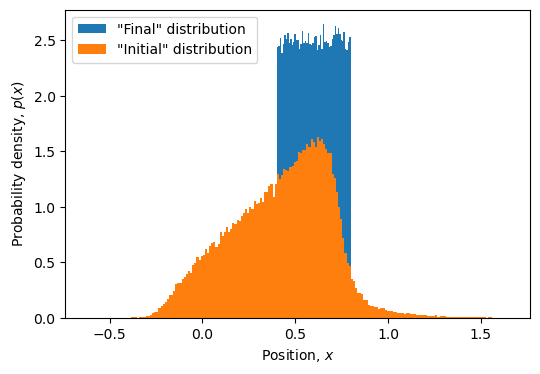

In [4]:
# and plot histogram for illustration
fig = plt.figure(figsize=(6,4))
plt.hist(X0_backward, bins=50, label='"Final" distribution', density=True)
plt.hist(X_backward, bins=200, label='"Initial" distribution', density=True)
plt.xlabel('Position, $x$')
plt.ylabel('Probability density, $p(x)$')
plt.legend()

# Forward SDE with filtering

Here, we start out particles using a dummy distribution, whose important properties are:
* Uniform
* Wide enough to contain all positions from which there is a non-negiligible probability of reaching the interval of the "final" distribution
  
We model their transport with the forward SDE. We then filter the solutions, keeping only the ones that end up within the interval given by the "final" distribution.

In [5]:
# Numerical parameters
# Note, we need more particles than above to get a smooth histogram,
# as we will discard most of the particles
Np = 100000
dt = 0.01

# Derived variables
Nt = int(Tmax / dt)

# Initial dummy distribution, uniform, and wide enough to cover all positions
# that have a non-negligible probability of reaching the interval defining
# the observed "final" distribution
X0_forward = np.random.uniform(low=-1, high=2, size=Np)

X_forward = X0_forward.copy()
t = 0
for n in range(Nt):
    X_forward = EM(X_forward, t, dt, a, b)
    t += dt

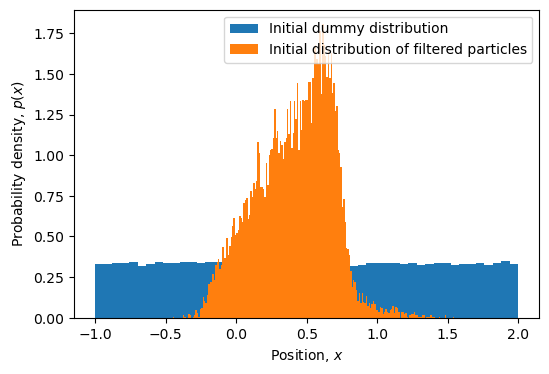

In [6]:
# Find distribution of particles that ended up within the specified interval
mask = np.abs(X_forward - X0_ref) < dX_ref

# and plot histogram for illustration
fig = plt.figure(figsize=(6,4))
plt.hist(X0_forward, bins=50, label='Initial dummy distribution', density=True)
plt.hist(X0_forward[mask], bins=200, label='Initial distribution of filtered particles', density=True)
plt.xlabel('Position, $x$')
plt.ylabel('Probability density, $p(x)$')
plt.legend()

# Numerical solution of backward Kolmogorov equation

Here, we solve the backward Kolmogorov with a finite difference implementation. We use the shorthand notation $p_j^i = p(y_j, s_i; x, t)$.

$$ p_j^i = p_j^{i+1} + \Delta t \left[ a(y_j, s_i) \frac{p_{j+1}^i - p_{j-1}^i}{2 \Delta x} + \frac{1}{2} b^2(y_j, s_i) \frac{p_{j+1}^i - 2p_{j}^i + p_{j-1}^i}{\Delta x^2} \right] $$

In [8]:
# Define coordinate axis
xc, dx = np.linspace(-2, 2, 1001, retstep=True)
# timestep
dt = 0.0001 # Must be short for stability
# timesteps
Nt = int(Tmax/dt)
# "initial" condition (actually final condition), normalised to 1
p0 = np.where(np.abs(xc - X0_ref) < dX_ref, 1., 0.) / (2*dX_ref)

# Run model
p = p0.copy()
t = Tmax
for i in range(Nt):
    # Hard-coded implementation of the finite difference scheme above
    # Note: We ignore the boundaries, which is fine if we stop the run
    # before the values at the boundary become non-negligible
    p[1:-1] = p[1:-1] + dt*(
        + a(xc[1:-1], t) * (p[2:] - p[:-2]) / (2*dx)
        + (1/2)*b(xc[1:-1], t)**2 * (p[2:] - 2*p[1:-1] + p[:-2]) / dx**2
    )
    t -= dt

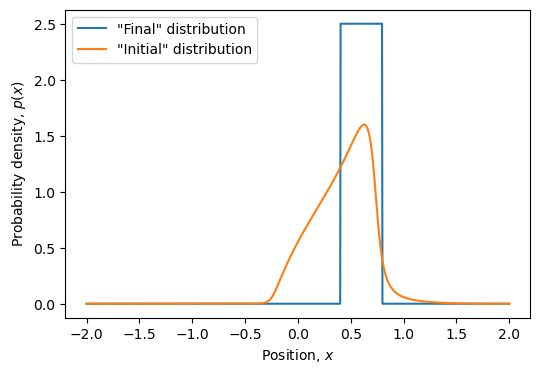

In [9]:
# Plot initial and final distributions
fig = plt.figure(figsize=(6,4))
plt.plot(xc, p0, label='"Final" distribution')
plt.plot(xc, p, label='"Initial" distribution')
plt.xlabel('Position, $x$')
plt.ylabel('Probability density, $p(x)$')
plt.legend()

# Plot everything together

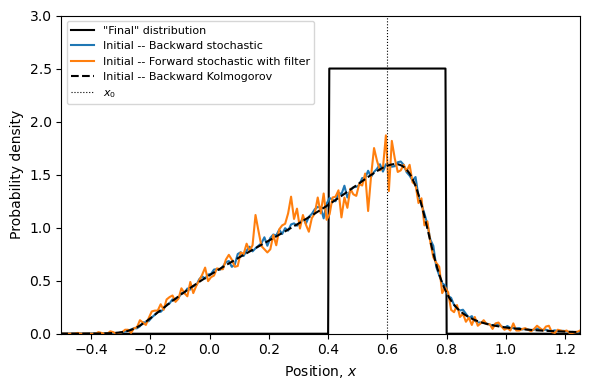

In [12]:
# Histogram bins for consistent plotting
bins = np.linspace(-0.5, 1.5, 201)
mids = bins[:-1] + (bins[1] - bins[0])/2

# Distribution of backwards particles
c_backward, _ = np.histogram(X_backward, bins=bins, density=True)
# Distribution of filtered forwards particles
mask = np.abs(X_forward - X0_ref) < dX_ref
c_forward, _ = np.histogram(X0_forward[mask], bins=bins, density=True)

fig = plt.figure(figsize=(6,4))
plt.plot(xc, p0, c='k', label='"Final" distribution')
plt.plot(mids, c_backward, label='Initial -- Backward stochastic')
plt.plot(mids, c_forward, label='Initial -- Forward stochastic with filter')
plt.plot(xc, p, '--', c='k', label='Initial -- Backward Kolmogorov')
plt.plot([X0_ref, X0_ref], [0, 3], ':', lw=0.8, c='k', label='$x_0$')
plt.legend(loc='upper left', fontsize=8)
plt.xlim(-0.5, 1.25)
plt.ylim(0, 3)
plt.ylabel('Probability density')
plt.xlabel('Position, $x$')
plt.tight_layout()
plt.savefig('numerical_examples.png', dpi=300)

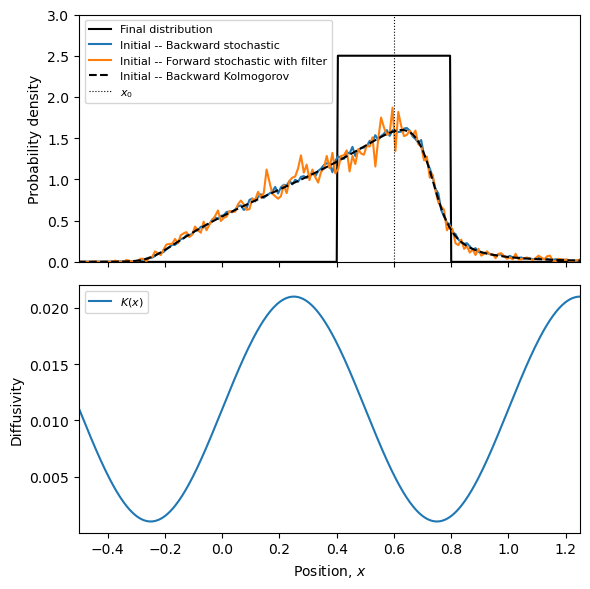

In [14]:
# Histogram bins for consistent plotting
bins = np.linspace(-0.5, 1.5, 201)
mids = bins[:-1] + (bins[1] - bins[0])/2

# Distribution of backwards particles
c_backward, _ = np.histogram(X_backward, bins=bins, density=True)
# Distribution of filtered forwards particles
mask = np.abs(X_forward - X0_ref) < dX_ref
c_forward, _ = np.histogram(X0_forward[mask], bins=bins, density=True)

fig, ax = plt.subplots(nrows=2, figsize=(6,6), sharex=True)
ax[0].plot(xc, p0, c='k', label='Final distribution')
ax[0].plot(mids, c_backward, label='Initial -- Backward stochastic')
ax[0].plot(mids, c_forward, label='Initial -- Forward stochastic with filter')
ax[0].plot(xc, p, '--', c='k', label='Initial -- Backward Kolmogorov')
ax[0].plot([X0_ref, X0_ref], [0, 3], ':', lw=0.8, c='k', label='$x_0$')

ax[1].plot(xc, K(xc, 0), label='$K(x)$')
plt.xlim(-0.5, 1.25)
ax[0].set_ylim(0, 3)
ax[0].set_ylabel('Probability density')
ax[1].set_ylabel('Diffusivity')
ax[1].set_xlabel('Position, $x$')
ax[0].legend(loc='upper left', fontsize=8)
ax[1].legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('numerical_examples_2.png', dpi=300)